In [1]:
# Append 'src' directory to import modules from notebooks directory
#################################
import os,sys
src_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(src_dir)
##################################

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

%pylab inline

import time
import os 
import torchvision.models as models
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.model_zoo as model_zoo
import cv2
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim 
from src.models import VGG19
from src import Utils
from src.PatchMatch import PatchMatchOrig

import scipy

Populating the interactive namespace from numpy and matplotlib


In [190]:
def blend_features(feat_a, recon_feat_bb, alpha=0.8, tau=0.05, k=300.):
    def sigmoid(x):
        return 1. / (1. + np.exp(-x))
    
    def clip_at_threshold(neuron_mag_a,clip_value=.05):
        neuron_mag_a[neuron_mag_a < clip_value] = 0
        return neuron_mag_a
    
    norm_feat_a = feat_a**2
    neuron_mag_a = (norm_feat_a - norm_feat_a.min(axis=(0,1,2),keepdims=True))/(norm_feat_a.max(axis=(0,1,2),keepdims=True)-norm_feat_a.min(axis=(0,1,2),keepdims=True))
    neuron_mag_a = clip_at_threshold(neuron_mag_a)
    neuron_mag_a = sigmoid(k*(neuron_mag_a - tau))
    weight_a = alpha*neuron_mag_a
    feat_aa = np.multiply(feat_a, weight_a) + np.multiply(recon_feat_bb, (1. - weight_a))
    return feat_aa

def normalize_feat_map(feat_map):
    """
    Normalize the feature map along the channels dimension
    
    feat_map is a numpy array with channels along the 2nd dimension
    """
    return feat_map/np.linalg.norm(feat_map,ord=2,axis=(2),keepdims=True)


## Defining the model from custom model class
The model class gives some extra functionality

In [191]:
c_feat_ids = [29,20,11,6,1]
c_alphas = [.8,.7,.6,.1]
c_patch_sizes = [3,3,3,5,5]
c_patch_radii = [500,6,6,4,4]

c_iters = [1700,1700,1700,1700]

In [54]:
model = VGG19()
model.model = model.model.cpu()

KeyboardInterrupt: 

In [192]:
model.model

FeatureExtractor (
  (conv_1_1__0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1__1): ReLU ()
  (conv_1_2__2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2__3): ReLU ()
  (pool_1__4): AvgPool2d (size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False, count_include_pad=True)
  (conv_2_1__5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1__6): ReLU ()
  (conv_2_2__7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2__8): ReLU ()
  (pool_2__9): AvgPool2d (size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False, count_include_pad=True)
  (conv_3_1__10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1__11): ReLU ()
  (conv_3_2__12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2__13): ReLU ()
  (conv_3_3__14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3__15): ReLU ()

In [193]:
model.model = model.model.cpu()

### Input Image Paths

In [194]:
imga_path = '../data/raw/mountain_green.png'
imgbb_path = '../data/raw/mountain_minecraft.png'

In [195]:
imga = Utils.load_image(img_path=imga_path,to_array=True,to_variable=True)
imgbb = Utils.load_image(img_path=imgbb_path,to_array=True,to_variable=True)

In [196]:
feata = model.get_features(img_tensor=imga)
featbb = model.get_features(img_tensor=imgbb)

In [197]:
feat5a = feata[c_feat_ids[0]]
feat5bb = featbb[c_feat_ids[0]]

In [198]:
feat5a_norm = normalize_feat_map(feat5a)
feat5bb_norm = normalize_feat_map(feat5bb)

In [199]:
pm5ab = PatchMatchOrig(feat5a_norm,feat5a_norm,feat5bb_norm,feat5bb_norm, c_patch_sizes[0])
# plt.imshow(pm5ab.visualize())
pm5ab.propagate(iters=5,rand_search_radius=c_patch_radii[0])
# plt.imshow(pm5ab.visualize())

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


In [200]:
imga_raw = Utils.load_image(img_path=imga_path,to_array=False,to_variable=False).numpy().transpose(1,2,0)
imgbb_raw = Utils.load_image(img_path=imgbb_path,to_array=False,to_variable=False).numpy().transpose(1,2,0)
imga_raw.shape

(224, 224, 3)

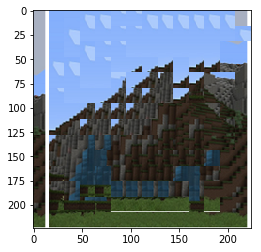

In [201]:
recon = pm5ab.reconstruct_image(imgbb_raw)
plt.imshow(Utils.deprocess_image(recon))

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


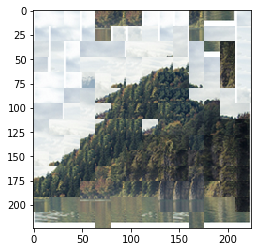

In [202]:
pm5ba = PatchMatchOrig(feat5bb_norm,feat5bb_norm,feat5a_norm,feat5a_norm,c_patch_sizes[0])
# plt.imshow(pm5ba.visualize())
pm5ba.propagate(iters=5,rand_search_radius=c_patch_radii[0])
# plt.imshow(pm5ba.visualize())
recon = pm5ba.reconstruct_image(imga_raw)
plt.imshow(Utils.deprocess_image(recon))

In [203]:
warped_feat5bb = pm5ab.reconstruct_image(feat5bb)
warped_feat5a = pm5ba.reconstruct_image(feat5a)


In [204]:
r4_bb = model.get_deconvoluted_feat(warped_feat5bb,5,iters=c_iters[0])
r4_a = model.get_deconvoluted_feat(warped_feat5a,5,iters=c_iters[0])

In [205]:
model.model = model.model.cpu()
feat4a = feata[c_feat_ids[1]]
feat4bb = featbb[c_feat_ids[1]]

In [206]:
feat4aa = blend_features(feat4a,r4_bb,alpha=c_alphas[0])
feat4b =  blend_features(feat4bb,r4_a,alpha=c_alphas[0])

In [207]:
feat4a_norm = normalize_feat_map(feat4a)
feat4bb_norm = normalize_feat_map(feat4bb)

feat4aa_norm = normalize_feat_map(feat4aa)
feat4b_norm = normalize_feat_map(feat4b)

In [208]:
model.model = model.model.cpu()

In [209]:
pm4ab = PatchMatchOrig(feat4a_norm,feat4aa_norm,feat4b_norm,feat4bb_norm, c_patch_sizes[1])
pm4ab.nnf = pm5ab.upsample_nnf(size=28)
pm4ab.propagate(iters=5,rand_search_radius=c_patch_radii[1])

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


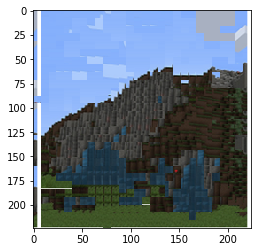

In [210]:
plt.imshow(Utils.deprocess_image(pm4ab.reconstruct_image(img_a=imgbb_raw)))

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


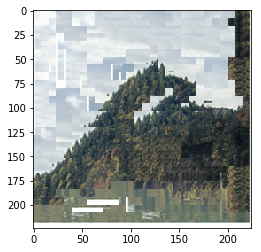

In [211]:
pm4ba = PatchMatchOrig(feat4bb_norm,feat4b_norm,feat4aa_norm,feat4a_norm, c_patch_sizes[1])
pm4ba.nnf = pm5ba.upsample_nnf(size=28)

pm4ba.propagate(iters=5,rand_search_radius=c_patch_radii[1])
plt.imshow(Utils.deprocess_image(pm4ba.reconstruct_image(img_a=imga_raw)))

In [212]:
warped_feat4bb = pm4ab.reconstruct_image(feat4bb)
warped_feat4a = pm4ba.reconstruct_image(feat4a,)

r3_bb = model.get_deconvoluted_feat(warped_feat4bb,4,iters=c_iters[1])
r3_a = model.get_deconvoluted_feat(warped_feat4a,4,iters=c_iters[1])

In [213]:
model.model = model.model.cpu()
feat3a = feata[c_feat_ids[2]]
feat3bb = featbb[c_feat_ids[2]]

In [214]:
feat3aa = blend_features(feat3a,r3_bb,alpha=c_alphas[1])
feat3b =  blend_features(feat3bb,r3_a,alpha=c_alphas[1])


In [215]:
feat3a_norm = normalize_feat_map(feat3a)
feat3bb_norm = normalize_feat_map(feat3bb)

feat3aa_norm = normalize_feat_map(feat3aa)
feat3b_norm = normalize_feat_map(feat3b)

In [216]:
pm3ab = PatchMatchOrig(feat3a_norm,feat3aa_norm,feat3b_norm,feat3bb_norm, c_patch_sizes[2])
pm3ab.nnf = pm4ab.upsample_nnf(size=56)

pm3ab.propagate(iters=5,rand_search_radius=c_patch_radii[2])

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


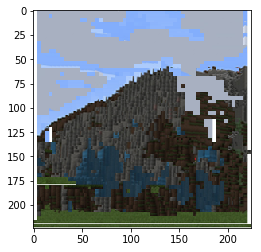

In [217]:
plt.imshow(Utils.deprocess_image(pm3ab.reconstruct_image(img_a=imgbb_raw)))

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


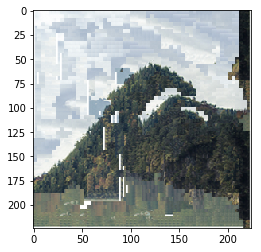

In [218]:
pm3ba = PatchMatchOrig(feat3bb_norm,feat3b_norm,feat3aa_norm,feat3a_norm, c_patch_sizes[2])
pm3ba.nnf = pm4ba.upsample_nnf(size=56)

pm3ba.propagate(iters=5,rand_search_radius=c_patch_radii[2])
plt.imshow(Utils.deprocess_image(pm3ba.reconstruct_image(img_a=imga_raw)))

In [219]:
warped_feat3bb = pm3ab.reconstruct_image(feat3bb)
warped_feat3a = pm3ba.reconstruct_image(feat3a)

r2_bb = model.get_deconvoluted_feat(warped_feat3bb,3,iters=c_iters[2])
r2_a = model.get_deconvoluted_feat(warped_feat3a,3,iters=c_iters[2])

In [220]:
model.model = model.model.cpu()
feat2a = feata[c_feat_ids[3]]
feat2bb = featbb[c_feat_ids[3]]

In [221]:
feat2aa = blend_features(feat2a,r2_bb,alpha=c_alphas[2])
feat2b = blend_features(feat2bb,r2_a,alpha=c_alphas[2])


In [222]:
feat2a_norm = normalize_feat_map(feat2a)
feat2bb_norm = normalize_feat_map(feat2bb)

feat2aa_norm = normalize_feat_map(feat2aa)
feat2b_norm = normalize_feat_map(feat2b)

In [223]:
pm2ab = PatchMatchOrig(feat2a_norm,feat2aa_norm,feat2b_norm,feat2bb_norm, c_patch_sizes[3])
pm2ab.nnf = pm3ab.upsample_nnf(size=112)

pm2ab.propagate(iters=5,rand_search_radius=c_patch_radii[3])

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


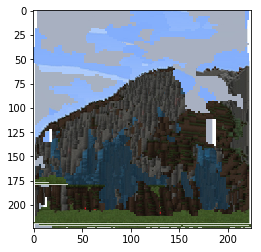

In [224]:
plt.imshow(Utils.deprocess_image(pm2ab.reconstruct_image(img_a=imgbb_raw)))

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


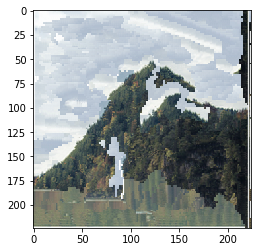

In [225]:
pm2ba = PatchMatchOrig(feat2bb_norm,feat2b_norm,feat2aa_norm,feat2a_norm, c_patch_sizes[3])
pm2ba.nnf = pm3ba.upsample_nnf(size=112)

pm2ba.propagate(iters=5,rand_search_radius=c_patch_radii[3])
plt.imshow(Utils.deprocess_image(pm2ba.reconstruct_image(img_a=imga_raw)))

In [226]:
warped_feat2bb = pm2ab.reconstruct_image(feat2bb)
warped_feat2a = pm2ba.reconstruct_image(feat2a)

r1_bb = model.get_deconvoluted_feat(warped_feat2bb,2,iters=c_iters[3])
r1_a = model.get_deconvoluted_feat(warped_feat2a,2,iters=c_iters[3])

In [227]:
model.model = model.model.cpu()
feat1a = feata[c_feat_ids[4]]
feat1bb = featbb[c_feat_ids[4]]

In [228]:
feat1aa = blend_features(feat1a,r1_bb,alpha=c_alphas[3])
feat1b = blend_features(feat1bb,r1_a,alpha=c_alphas[3])

In [229]:
feat1a_norm = normalize_feat_map(feat1a)
feat1bb_norm = normalize_feat_map(feat1bb)

feat1aa_norm = normalize_feat_map(feat1aa)
feat1b_norm = normalize_feat_map(feat1b)

In [230]:
pm1ab = PatchMatchOrig(feat1a_norm,feat1aa_norm,feat1b_norm,feat1bb_norm, c_patch_sizes[4])
pm1ab.nnf = pm2ab.upsample_nnf(size=224)

pm1ab.propagate(iters=5,rand_search_radius=c_patch_radii[4])

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


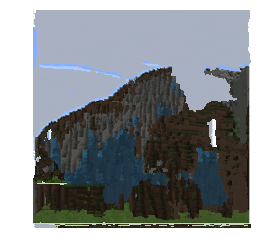

In [231]:
plt.axis('off')
plt.imshow(Utils.deprocess_image(pm1ab.reconstruct_image(img_a=imgbb_raw)))

In [232]:
pm1ba = PatchMatchOrig(feat1bb_norm,feat1b_norm,feat1aa_norm,feat1a_norm, c_patch_sizes[4])
pm1ba.nnf = pm2ba.upsample_nnf(size=224)

pm1ba.propagate(iters=5,rand_search_radius=c_patch_radii[4])

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done All Iterations


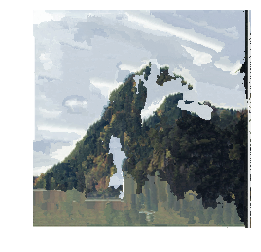

In [233]:
plt.axis('off')
plt.imshow(Utils.deprocess_image(pm1ba.reconstruct_image(img_a=imga_raw)))

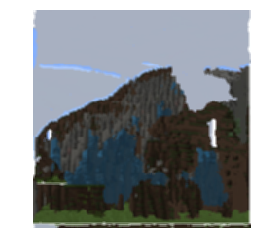

In [234]:
ups = pm2ba.upsample_nnf(size=224)
plt.axis('off')
resB = np.clip(Utils.deprocess_image(pm1ab.reconstruct_avg(imgbb_raw,patch_size=2)),0,1)

plt.imshow(resB)
plt.imsave('/tmp/mona.png',resB)

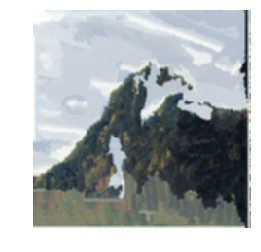

In [235]:
ups = pm1ba.upsample_nnf(size=224)
plt.axis('off')
resAA = np.clip(Utils.deprocess_image(pm1ba.reconstruct_avg(imga_raw,patch_size=2)),0,1)
plt.imshow(resAA)

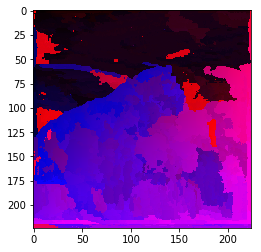

In [236]:
plt.imshow(pm1ab.visualize())

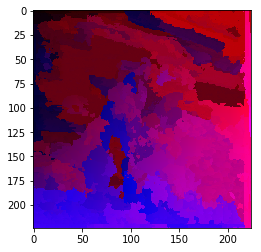

In [237]:
plt.imshow(pm1ba.visualize())